# Part II - Classification Task

## Pen-Based Recognition of Handwritten Digits Data Set

It is a simple and well-known image bank for image recognition. It consists of 8-by-8-pixel gray-scale images divided into 10 classes of digits. And we want to solve it as a classification task using supervised learning methods.

In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objects as go

from sklearn import svm, metrics
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import normalize

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Plot methods

In [2]:
def plot_2d(first_component, second_component):
    fig = go.Figure(data=go.Scatter(
        x = first_component,
        y = second_component,
        mode = 'markers',
        marker=dict(
        size=8,
        color= second_component, #set color equal to a variable
        colorscale='Rainbow', # one of plotly colorscales
        showscale=True,
        line_width=1
        )
    ))
    fig.update_layout(margin=dict( l=100,r=100,b=100,t=100),width=700,height=500)                 
    fig.layout.template = 'plotly_dark'

    fig.show()

In [3]:
def plot_3d(component1,component2,component3):
    fig = go.Figure(data=[go.Scatter3d(
        x=component1,
        y=component2,
        z=component3,
        mode='markers',
        marker=dict(
            size=5,
            color=component2,
            colorscale='Rainbow',
            opacity=1,
            line_width=1
        )
    )])
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=700,height=500)
    fig.layout.template = 'plotly_dark'
    
    fig.show()

## Loading dataset from sklearn

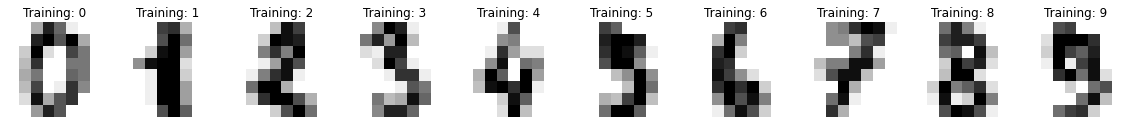

In [4]:
digits = load_digits()

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

### Normalizing and splitting dataset

In [5]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

data_normalized = normalize(data, norm='max')

training_set, test_set, training_target, test_target = train_test_split(data_normalized, digits.target, test_size=0.1, shuffle=False)

## t-SNE

In [6]:
start = time.time()
pca_50 = PCA(n_components=64)
pca_result_50 = pca_50.fit_transform(data_normalized)
tsne = TSNE(random_state = 42, n_components=3,verbose=0, perplexity=40, n_iter=400).fit_transform(pca_result_50)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 21.69818425178528 seconds


In [7]:
plot_2d(tsne[:, 0],tsne[:, 1])

In [8]:
plot_3d(tsne[:, 0],tsne[:, 1],tsne[:, 2])

## Decision Tree Classifier

In [48]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier()

cross_validation_tree = cross_validate(clf_tree, training_set, training_target, return_estimator=True)
print(cross_validation_tree['test_score'])
print('We can observe that the split with index %d has the best score of: %0.3f.' % (np.argmax(cross_validation_tree['test_score']), cross_validation_tree['test_score'].max()))

print("From cross validation we obtain %0.3f accuracy with a standard deviation of %0.3f." % (cross_validation_tree['test_score'].mean(), cross_validation_tree['test_score'].std()))

[0.77469136 0.76234568 0.78328173 0.87616099 0.73374613]
We can observe that the split with index 3 has the best score of: 0.876.
From cross validation we obtain 0.786 accuracy with a standard deviation of 0.048.


In [49]:
cross_validation_tree['estimator'][np.argmax(cross_validation_tree['test_score'])].fit(training_set, training_target)

predicted_tree = cross_val_predict(cross_validation_tree['estimator'][np.argmax(cross_validation_tree['test_score'])], test_set, test_target)

print("Without cross validation we obtain a score of %0.3f." % (cross_validation_tree['estimator'][np.argmax(cross_validation_tree['test_score'])].score(test_set, test_target)))

Without cross validation we obtain a score of 0.817.


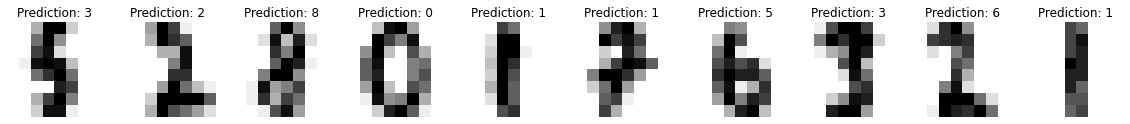

In [11]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))
for ax, image, prediction in zip(axes, test_set, predicted_tree):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction}')

In [50]:
print(f"Classification report for classifier {cross_validation_tree['estimator'][np.argmax(cross_validation_tree['test_score'])]}:\n"
      f"{metrics.classification_report(test_target, predicted_tree)}\n")

Classification report for classifier DecisionTreeClassifier():
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       0.57      0.68      0.62        19
           2       0.71      0.59      0.65        17
           3       0.62      0.83      0.71        18
           4       0.68      0.65      0.67        20
           5       0.69      0.50      0.58        18
           6       0.65      0.72      0.68        18
           7       0.79      0.58      0.67        19
           8       0.58      0.41      0.48        17
           9       0.62      0.83      0.71        18

    accuracy                           0.67       180
   macro avg       0.68      0.67      0.67       180
weighted avg       0.68      0.67      0.67       180




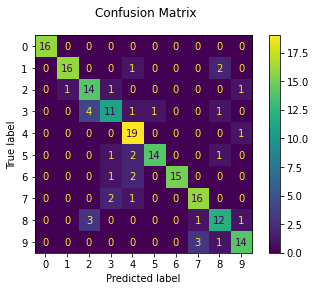

In [51]:
disp = metrics.plot_confusion_matrix(cross_validation_tree['estimator'][np.argmax(cross_validation_tree['test_score'])], test_set, test_target)
disp.figure_.suptitle("Confusion Matrix")

plt.show() 

## C-Support Vector Classification

Support-vector machines (aka SVMs) are popular supervised learning models with algorithms able to classify, analyze regression and other learning tasks. SVM usually tries to create a line or frontier that maximizes the margin between data classes. This line is called hyperplane, the distance between the hyperplane and the closest elements is the margin and the vectors that define the hyperplane are called support vectors, which give its name. 

In this project we used C-Support Vector Classification from sklearn lib that is based on libsvm. C stands for its regularization parameter, the strength of the regularization is inversely proportional to C. And we specify the kernel type to be used in the algorithm, 'poly'.

In [41]:
clf_svc = svm.SVC(kernel='poly')

cross_validation_svc = cross_validate(clf_svc, training_set, training_target, return_estimator=True)
print(cross_validation_svc['test_score'])
print(np.argmax(cross_validation_svc['test_score']))
print('We can observe that the split with index %d has the best score of: %0.3f.' % (np.argmax(cross_validation_svc['test_score']), cross_validation_svc['test_score'].max()))

print("From cross validation we obtain %0.3f accuracy with a standard deviation of %0.3f." % (cross_validation_svc['test_score'].mean(), cross_validation_svc['test_score'].std()))

[0.97839506 0.91666667 0.97832817 0.98142415 0.9504644 ]
3
We can observe that the split with index 3 has the best score of: 0.981.
From cross validation we obtain 0.961 accuracy with a standard deviation of 0.025.


In [44]:
cross_validation_svc['estimator'][np.argmax(cross_validation_svc['test_score'])].fit(training_set, training_target)

predicted_svc = cross_val_predict(cross_validation_svc['estimator'][np.argmax(cross_validation_svc['test_score'])], test_set, test_target)

print("Without cross validation we obtain a score of %0.3f." % (cross_validation_svc['estimator'][np.argmax(cross_validation_svc['test_score'])].score(test_set, test_target)))

Without cross validation we obtain a score of 0.967.


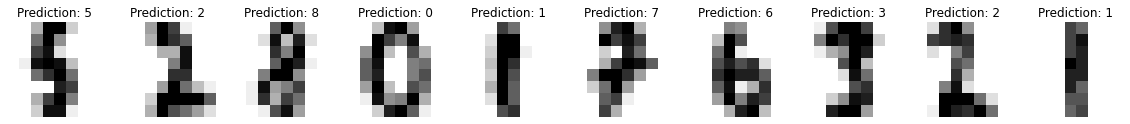

In [30]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))
for ax, image, prediction in zip(axes, test_set, predicted_svc):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction}')

In [45]:
print(f"Classification report for classifier {cross_validation_svc['estimator'][np.argmax(cross_validation_svc['test_score'])]}:\n"
      f"{metrics.classification_report(test_target, predicted_svc)}\n")

Classification report for classifier SVC(kernel='poly'):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        18
           4       0.95      1.00      0.98        20
           5       0.94      0.94      0.94        18
           6       1.00      1.00      1.00        18
           7       0.95      1.00      0.97        19
           8       0.94      0.88      0.91        17
           9       0.94      0.89      0.91        18

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180




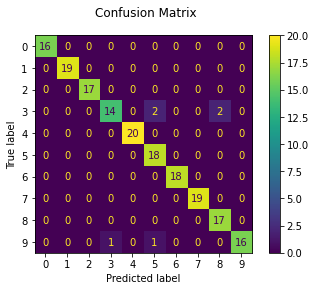

In [46]:
disp = metrics.plot_confusion_matrix(cross_validation_svc['estimator'][np.argmax(cross_validation_svc['test_score'])], test_set, test_target)
disp.figure_.suptitle("Confusion Matrix")

plt.show() 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f96ded6d-d068-4049-b80f-7d8e29514f85' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>